In [1]:
import os
# numpy
import numpy as np
np.random.seed(42)
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# ML-utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split

In [2]:
import sys

module_path = os.path.abspath(os.path.join(os.pardir, 'src'))

if module_path not in sys.path:
    sys.path.append(module_path)

from data.load_data import load_dicom, load_nrrd 

In [3]:
seed = 42

In [4]:
# I/O

# Data directory
raw_dicom_folder = os.path.abspath('../data/raw/images')
raw_nrrd_folder = os.path.abspath('../data/raw/masks')

# 1. Data loading

## 1.1. Loading DICOMs as `np.ndarray`

In [5]:
dcm_array = load_dicom(raw_dicom_folder)

140 DICOM images loaded.


In [6]:
dcm_array.shape

(140, 512, 512, 1)

## 1.3. Loading `nrrd` masks

In [7]:
mask={}

In [8]:
region_0 = load_nrrd(raw_nrrd_folder, 'region 0')

140 .nrrd masks loaded.


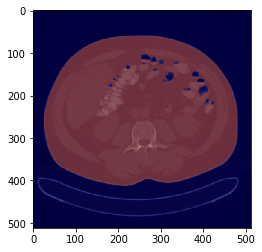

In [9]:
plt.imshow(dcm_array[2, :, :, 0], cmap=plt.cm.bone, interpolation='nearest')
plt.imshow(region_0[2, :, :, 0], cmap='jet', alpha=0.5, interpolation='nearest');

To get **background mask** we need to **invert region 0** - *all tissues* mask

In [13]:
# loading all masks
background = np.logical_not(load_nrrd(raw_nrrd_folder, 'region 0'))
subcutaneous_fat_mask = load_nrrd(raw_nrrd_folder, 'region 1')
intramuscular_fat_mask = load_nrrd(raw_nrrd_folder, 'region 2')
skeletal_muscle_mask = load_nrrd(raw_nrrd_folder, 'region 3')
visceral_fat_mask = load_nrrd(raw_nrrd_folder, 'region 4')

140 .nrrd masks loaded.
140 .nrrd masks loaded.
140 .nrrd masks loaded.
140 .nrrd masks loaded.
140 .nrrd masks loaded.


# 2. Data preprocessing
## 2.1. Normalization

In [26]:
def normalize(train_array, test_array, scaler): 
    scaled_train_arr = scaler.fit_transform(train_array)
    scaled_test_arr = scaler.transform(test_array)
    return scaled_train_arr, scaled_test_arr

## 2.2. Image & mask augmenation 

In [70]:
# create image data augmentation generator
data_gen_args = dict(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

In [75]:
image_datagen.fit(dcm_array, augment=True, seed=seed)
mask_datagen.fit(background, augment=True, seed=seed)

In [ ]:
image_generator = image_datagen.flow(dcm_array, seed=seed)
mask_generator = mask_datagen.flow(background, seed=seed)

In [ ]:
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

id = 0  # Use whatever method you wish for a name with no collision.
for images, masks in train_generator:
    for image, mask in zip(images, masks):
        np.save('data/aug_images/images/' + str(id), image)
        np.save('data/aug_images/masks/' + str(id), mask)
        id += 1

model.fit_generator(
    train_generator,
    steps_per_epoch=2000,
    epochs=50)